# Linear regression 

In this exercise you will use linear regression to predict flat prices. Training will be handled via gradient descent and we will:
* have multiple features (i.e. variables used to make the prediction),
* employ some basic feature engineering,
* work with a non-standard loss function.

Let's start with getting the data.

In [ ]:
%matplotlib inline

!wget -O mieszkania.csv https://www.dropbox.com/s/zey0gx91pna8irj/mieszkania.csv?dl=1
!wget -O mieszkania_test.csv https://www.dropbox.com/s/dbrj6sbxb4ayqjz/mieszkania_test.csv?dl=1

--2021-11-08 21:31:32--  https://www.dropbox.com/s/zey0gx91pna8irj/mieszkania.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/zey0gx91pna8irj/mieszkania.csv [following]
--2021-11-08 21:31:32--  https://www.dropbox.com/s/dl/zey0gx91pna8irj/mieszkania.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc23fd3cb1022fa19b4c736fc2c8.dl.dropboxusercontent.com/cd/0/get/BZnfbTixqwdiJt2pEITOUlYaLaM6_T-ULg9ywJPr4QxbTZyL9Gu_2cHKUTde6IiFjj5cBq4LPCvpnzTpQoigBA2c7sw3EMmX-uyqJWiyCd-2AsFrSai8zV4cTm3bD6cm7PIAdTChYu74tFKW60B4_Ft0/file?dl=1# [following]
--2021-11-08 21:31:32--  https://uc23fd3cb1022fa19b4c736fc2c8.dl.dropboxusercontent.com/cd/0/get/BZnfbTixqwdiJt2pEITOUlYaLaM6_T-ULg9ywJPr4QxbTZyL9Gu_2cHKUTde6IiFjj5cBq4LPCvpnzTpQo

In [ ]:
!head mieszkania.csv mieszkania_test.csv

==> mieszkania.csv <==
m2,dzielnica,ilość_sypialni,ilość_łazienek,rok_budowy,parking_podziemny,cena
104,mokotowo,2,2,1940,1,780094
43,ochotowo,1,1,1970,1,346912
128,grodziskowo,3,2,1916,1,523466
112,mokotowo,3,2,1920,1,830965
149,mokotowo,3,3,1977,0,1090479
80,ochotowo,2,2,1937,0,599060
58,ochotowo,2,1,1922,0,463639
23,ochotowo,1,1,1929,0,166785
40,mokotowo,1,1,1973,0,318849

==> mieszkania_test.csv <==
m2,dzielnica,ilość_sypialni,ilość_łazienek,rok_budowy,parking_podziemny,cena
71,wolowo,2,2,1912,1,322227
45,mokotowo,1,1,1938,0,295878
38,mokotowo,1,1,1999,1,306530
70,ochotowo,2,2,1980,1,553641
136,mokotowo,3,2,1939,1,985348
128,wolowo,3,2,1983,1,695726
23,grodziskowo,1,1,1975,0,99751
117,mokotowo,3,2,1942,0,891261
65,ochotowo,2,1,2002,1,536499


Each row in the data represents a separate property. Our goal is to use the data from `mieszkania.csv` to create a model that can predict a property's price (i.e. `cena`) given its features (i.e. `m2,dzielnica,ilosc_sypialni,ilosc_lazienek,rok_budowy,parking_podziemny`). 

From now on, we should interfere only with `mieszkania.csv` (dubbed the training dataset) to make our decisions and create the model. The (only) purpose of `mieszkania_test.csv` is to test our model on **unseen** data.

Our predictions should minimize the so-called mean squared logarithmic error:
$$
MSLE = \frac{1}{n} \sum_{i=1}^n (\log(1+y_i) - \log(1+p_i))^2,
$$
where $y_i$ is the ground truth, and $p_i$ is our prediction.

Let's start with implementing the loss function.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def msle(ys, ps):
    assert len(ys) == len(ps)
###################################################
    SLE = (np.log(1+ys) - np.log(1+ps))**2
    return SLE.mean()
###################################################

The simplest model is predicting the same constant for each instance. Test your implementation of msle against outputing the mean price.

In [ ]:
###################################################
train = pd.read_csv('mieszkania.csv')
test = pd.read_csv('mieszkania_test.csv')

total = pd.concat([train, test])
total = pd.get_dummies(total, prefix='dzielnica')
print(total.head())

train = total[:len(train)]
test = total[len(train):]

cena = train['cena']
mean_price = cena.mean()
msle_train = msle(cena, np.full_like(cena, mean_price))

print(f'MSLE: {msle_train}')
###################################################

    m2  ilość_sypialni  ...  dzielnica_ochotowo  dzielnica_wolowo
0  104               2  ...                   0                 0
1   43               1  ...                   1                 0
2  128               3  ...                   0                 0
3  112               3  ...                   0                 0
4  149               3  ...                   0                 0

[5 rows x 10 columns]
MSLE: 0.39152503893367374


Recall that outputing the mean minimzes $MSE$. However, we're now dealing with $MSLE$.

Think of a constant that should result in the lowest $MSLE$.

In [ ]:
#############################################
const = np.exp(np.mean(np.log(train['cena'] + 1))) - 1
msle_train = msle(train['cena'], np.full_like(cena, const))

print(f'MSLE: {msle_train}')
#############################################

MSLE: 0.36488961221465716


Now, let's implement a standard linear regression model. 

In [ ]:
def create_sets(train, test):
    train_y = train['cena']
    test_y = test['cena']

    train_x = train.drop('cena', axis=1)
    test_x = test.drop('cena', axis=1)

    std = train_x.std()
    mean = train_x.mean()

    train_x = (train_x - mean) / std
    test_x = (test_x - mean) / std

    train_x = np.hstack([np.ones([len(train_y), 1]), train_x])
    test_x = np.hstack([np.ones([len(test_y), 1]), test_x])

    return train_x, train_y, test_x, test_y


train_x, train_y, test_x, test_y = create_sets(train, test)

In [ ]:
##########################################################
class Linear_Regression:
    def __init__(self, n, n_epoch, lr):
        self.n = n
        self.n_epoch = n_epoch
        self.lr = lr
        self.weights = None

    def evaluate(self, x, y):
        predictions = x @ self.weights
        return np.mean((y-predictions)**2)

    def fit(self, x, y):
        self.weights = np.zeros(x.shape[1])

        for i in range(self.n_epoch):
            predictions = x @ self.weights
            gradient = (2 / self.n) * (x.T @ (predictions - y))
            self.weights -= self.lr * gradient
        
            if i % 10000 == 0:
                loss = self.evaluate(x, y)
                print(f'Loss: {np.round(loss, 10)}')

    def predict(self, x):
        return x @ self.weights

##########################################################

In [ ]:
linear_regression = Linear_Regression(len(train_y), 100000, 0.001)
linear_regression.fit(train_x, train_y)
predictions = linear_regression.predict(test_x)
print(f'MSLE: {msle(test_y, predictions)}')

Loss: 330053251635.9377
Loss: 4158724102.5241227
Loss: 3910094990.152733
Loss: 3874334355.576732
Loss: 3869190066.2049327
Loss: 3868450042.5292225
Loss: 3868343587.5845113
Loss: 3868328273.675476
Loss: 3868326070.717124
Loss: 3868325753.814004
MSLE: 0.1809795461779234


Note that the loss function that the algorithms optimizes (i.e $MSE$) differs from $MSLE$. We've already seen that this may result in a suboptimal solution.

How can you change the setting so that we optimze $MSLE$ instead?

Hint: 
<sub><sup><sub><sup><sub><sup>
Be lazy. We don't want to change the algorithm.
</sup></sub></sup></sub></sup></sub>

In [ ]:
#############################################
linear_regression.fit(train_x, np.log1p(train_y))
predictions = np.expm1(linear_regression.predict(test_x))
print(f'MSLE: {msle(test_y, predictions)}')
#############################################

Loss: 168.0361789082
Loss: 0.0320865018
Loss: 0.0305111138
Loss: 0.0302845598
Loss: 0.0302519693
Loss: 0.030247281
Loss: 0.0302466066
Loss: 0.0302465095
Loss: 0.0302464956
Loss: 0.0302464936
MSLE: 0.036569043135465516


Without any feature engineering our model approximates the price as a linear combination of original features:
$$
\text{price} \approx w_1 \cdot \text{area} + w_2 \cdot \text{district} + \dots.
$$
Let's now introduce some interactions between the variables. For instance, let's consider a following formula:
$$
\text{price} \approx w_1 \cdot \text{area} \cdot \text{avg. price in the district per sq. meter} + w_2 \cdot \dots + \dots.
$$
Here, we model the price with far greater granularity, and we may expect to see more acurate results.

Add some feature engineering to your model. Be sure to play with the data and not with the algorithm's code. 

Think how to make sure that your model is capable of capturing the $w_1 \cdot \text{area} \cdot \text{avg. price...}$ part, without actually computing the averages.

Hint: 
<sub><sup><sub><sup><sub><sup>
Is having a binary encoding for each district and multiplying it by area enough?
</sup></sub></sup></sub></sup></sub>

Hint 2: 
<sub><sup><sub><sup><sub><sup>
Why not multiply everything together? I.e. (A,B,C) -> (AB,AC,BC).
</sup></sub></sup></sub></sup></sub>

In [ ]:
###############################################
from itertools import permutations

def get_multiplied_columns(df):
    df = df.copy()

    for a,b in permutations(np.arange(df.shape[1]), 2):
        new_column = df[:, a] * df[:, b]
        df = np.hstack([df, new_column.reshape(-1, 1)])

    return df
###############################################

In [ ]:
##############################################################
train_x_multiplied = get_multiplied_columns(train_x[:, 1:])
train_x_multiplied = np.hstack([np.ones([len(test_y), 1]), train_x_multiplied])

test_x_multiplied = get_multiplied_columns(test_x[:, 1:])
test_x_multiplied = np.hstack([np.ones([len(test_y), 1]), test_x_multiplied])

linear_regression.fit(train_x_multiplied, np.log1p(train_y))
predictions = np.expm1(linear_regression.predict(test_x_multiplied))

print(f'MSLE: {msle(test_y, predictions)}')
##############################################################

Loss: 163.9351316628
Loss: 0.0120138416
Loss: 0.0073465535
Loss: 0.0069542173
Loss: 0.0069172659
Loss: 0.0069135536
Loss: 0.0069131421
Loss: 0.006913089
Loss: 0.0069130807
Loss: 0.0069130792
MSLE: 0.019053141387974686


# Validation and cross-validation 

In this exercise you will implement a validation pipeline. 

At the end of the MSLE exercise you tested your model against the training and test datasets. As you should observe, there's a gap between the results. By validating your model, not only should you be able to anticipate the test time performance, but also have a method to compare different models.

Implement the basic validation method, i.e. a random split. Test it with your model from Exercise MSLE.

In [ ]:
#######################################################
from sklearn.utils import shuffle

def random_split(x, y, train_size):
    assert len(x) == len(y)
    assert train_size >=0 and train_size <= 1

    x, y = shuffle(x,y)
    train_size = int(len(x) * train_size)

    return x[:train_size], y[:train_size], x[train_size:], y[train_size:]


for _ in range(5):
    train_x_split, train_y_split, valid_x_split, valid_y_split = random_split(train_x, train_y, 0.3)

    linear_regression.fit(train_x_split, np.log1p(train_y_split))
    predictions = np.expm1(linear_regression.predict(valid_x_split))
    print(f'MSLE: {msle(valid_y_split, predictions)}')
#######################################################

Loss: 165.6719087872
Loss: 0.0717848624
Loss: 0.0507359371
Loss: 0.0455889524
Loss: 0.0428379166
Loss: 0.0412213192
Loss: 0.040256455
Loss: 0.0396791922
Loss: 0.0393336984
Loss: 0.0391269075
MSLE: 0.03295758028071103
Loss: 169.8100959868
Loss: 0.0541652823
Loss: 0.0402535608
Loss: 0.0343585967
Loss: 0.0311525195
Loss: 0.0294072645
Loss: 0.0284570994
Loss: 0.0279397938
Loss: 0.0276581524
Loss: 0.0275048157
MSLE: 0.03493088827026254
Loss: 170.0423041028
Loss: 0.0544876721
Loss: 0.0193681209
Loss: 0.0167270116
Loss: 0.0162793469
Loss: 0.016141621
Loss: 0.0160708218
Loss: 0.0160271885
Loss: 0.0159991943
Loss: 0.0159810936
MSLE: 0.0426911042042249
Loss: 165.4794728739
Loss: 0.0416663202
Loss: 0.0349279029
Loss: 0.0332560589
Loss: 0.0323635613
Loss: 0.0318560919
Loss: 0.0315629946
Loss: 0.0313930834
Loss: 0.0312944991
Loss: 0.0312372878
MSLE: 0.03816167339418241
Loss: 168.2910509988
Loss: 0.0463713518
Loss: 0.0331591604
Loss: 0.0311627905
Loss: 0.0304698762
Loss: 0.030112243
Loss: 0.02989630

To make the random split validation reliable, a huge chunk of training data may be needed. To get over this problem, one may apply cross-validaiton.

![alt-text](https://chrisjmccormick.files.wordpress.com/2013/07/10_fold_cv.png)

Let's now implement the method. Make sure that:
* number of partitions is a parameter,
* the method is not limited to `mieszkania.csv`,
* the method is not limited to one specific model.

In [ ]:
####################################
def cross_validation(x, y, k):
    assert len(x) == len(y)
    assert k >= 1 and k <= len(x)

    x, y = shuffle(x,y)
    chunk_size = int(len(x)/k)
    losses = []
    linear_regression = Linear_Regression(len(train_y), 100000, 0.001)

    for i in range(k):
        chunk_x = x[i*chunk_size : (i+1)*chunk_size]
        chunk_y = y[i*chunk_size : (i+1)*chunk_size]

        rest_x = np.concatenate([x[ : i*chunk_size], x[(i+1)*chunk_size : ]])
        rest_y = np.concatenate([y[ : i*chunk_size], y[(i+1)*chunk_size : ]])

        linear_regression.fit(rest_x, np.log1p(rest_y))
        predictions = np.expm1(linear_regression.predict(chunk_x))
        losses.append(msle(chunk_y, predictions))

    return losses

    
losses = cross_validation(train_x, train_y, 5)
print(f'Mean od MSLE: {np.mean(losses)}')
####################################

Loss: 167.9988338149
Loss: 0.0311935832
Loss: 0.0304250199
Loss: 0.0302525352
Loss: 0.0302138246
Loss: 0.0302051368
Loss: 0.030203187
Loss: 0.0302027495
Loss: 0.0302026513
Loss: 0.0302026292
Loss: 168.5846701728
Loss: 0.0334892434
Loss: 0.0315421021
Loss: 0.0311711531
Loss: 0.031100423
Loss: 0.0310869367
Loss: 0.0310843652
Loss: 0.0310838748
Loss: 0.0310837814
Loss: 0.0310837635
Loss: 168.0374434798
Loss: 0.03598563
Loss: 0.0332859832
Loss: 0.0327291288
Loss: 0.0326126575
Loss: 0.0325882952
Loss: 0.0325831993
Loss: 0.0325821334
Loss: 0.0325819105
Loss: 0.0325818638
Loss: 168.2249635871
Loss: 0.0288163921
Loss: 0.027281315
Loss: 0.0269471475
Loss: 0.0268722135
Loss: 0.0268554083
Loss: 0.0268516395
Loss: 0.0268507943
Loss: 0.0268506047
Loss: 0.0268505622
Loss: 167.9865932998
Loss: 0.0345396868
Loss: 0.0300137919
Loss: 0.0289595637
Loss: 0.0287137497
Loss: 0.0286564331
Loss: 0.0286430686
Loss: 0.0286399524
Loss: 0.0286392258
Loss: 0.0286390563
Mean od MSLE: 0.03374777414743376


Recall that sometimes validation may be tricky, e.g. significant class imbalance, having a small number of subjects, geographically clustered instances...

What could in theory go wrong here with random, unstratified partitions? Think about potential solutions and investigate the data in order to check whether these problems arise here.

[]

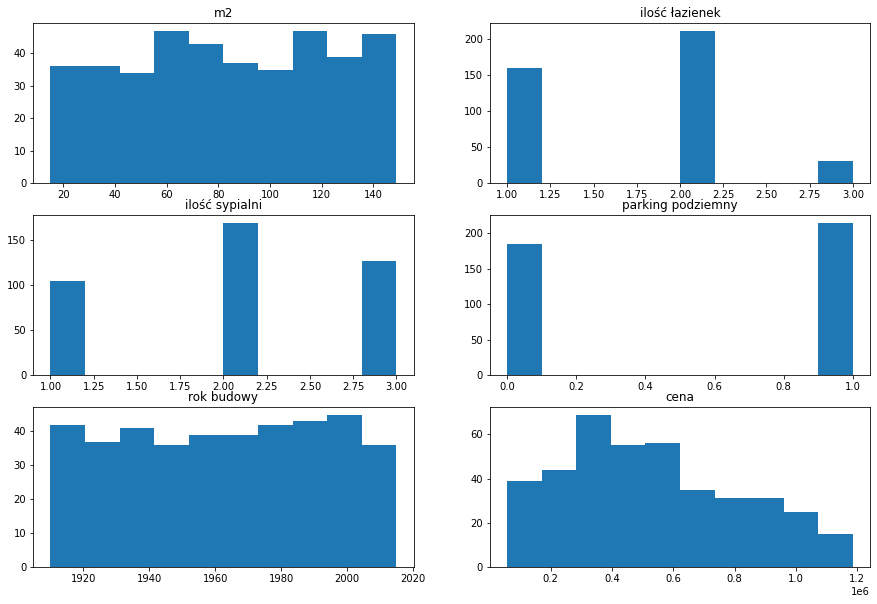

In [ ]:
##############################
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

plt.subplot(3,2,1)
plt.hist(total['m2'])
plt.title('m2')

plt.subplot(3,2,2)
plt.hist(total['ilość_łazienek'])
plt.title('ilość łazienek')

plt.subplot(3,2,3)
plt.hist(total['ilość_sypialni'])
plt.title('ilość sypialni')

plt.subplot(3,2,4)
plt.hist(total['parking_podziemny'])
plt.title('parking podziemny')

plt.subplot(3,2,5)
plt.hist(total['rok_budowy'])
plt.title('rok budowy')

plt.subplot(3,2,6)
plt.hist(total['cena'])
plt.title('cena')

plt.plot()
##############################